In [1]:
import numpy as np
from xml.etree.ElementTree import QName
import xml.etree.ElementTree
import dill
from tqdm import tqdm
import shapefile # pip install pyshp
from xml.etree.ElementTree import QName
import xml.etree.ElementTree
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
import random
import utm
import json
import shapely
from shapely import geometry
from matplotlib.pyplot import *
%matplotlib inline

# parse official S2 kml to dictionary

In [2]:
# https://sentinel.esa.int/web/sentinel/missions/sentinel-2/data-products # from here
fn = "./S2A_OPER_GIP_TILPAR_MPC__20151209T095117_V20150622T000000_21000101T000000_B00.kml"
namespace = "http://www.opengis.net/kml/2.2"

def ss(name):
    return str(QName(namespace,name))
def fnd(xml_root,*pp):
    bf = xml_root
    for p in pp:
        bf = bf.find(str(QName(namespace,p)))
    return bf

xml_root = xml.etree.ElementTree.parse(fn).getroot()
pms = fnd(xml_root,*("Document","Folder")).findall(ss("Placemark"))

In [3]:
def from_pm(pm):
    res = {}
    
    name = fnd(pm,"name").text
    zone = int(name[:2])
    res["name"] = name
    res["zone"] = zone
    
    desc = [sp.getText() for sp in bs(fnd(pm,"description").text,"lxml").findAll("td")]
    epsg = int(desc[desc.index("EPSG")+1])
    res["epsg"] = epsg

    try:
        ele = fnd(pm,*("MultiGeometry","Polygon","outerBoundaryIs","LinearRing","coordinates"))
        coo = [[float(ff) for ff in st.split(",")[:2]][::-1] for st in ele.text.strip().split(" ")][:-1] # list of lat/lon
        coords = [{name:value for name,value in zip(["lat","lon","x","y"],cc+list(utm.from_latlon(*cc,force_zone_number=zone))[:2])} for cc in coo]
        mean_x = np.mean([co["x"] for co in coords])
        mean_y = np.mean([co["y"] for co in coords])
        pos = {}
        for cord in coords:
            lr = "l" if cord["x"]<mean_x else "r"
            lt = "t" if cord["y"]>mean_y else "l"            
            if "%s%s" % (lt,lr) in  pos:
                raise utm.OutOfRangeError            
            pos["%s%s" % (lt,lr)] = cord    
        res["pos"] = pos
    except utm.OutOfRangeError:
        ele = fnd(pm,*("MultiGeometry","Polygon","outerBoundaryIs","LinearRing","coordinates"))
        coo = [[float(ff) for ff in st.split(",")[:2]][::-1] for st in ele.text.strip().split(" ")][:-1] # list of lat/lon
        pos = {pp:{name:value for name,value in zip(["lat","lon"],cc)} for pp,cc in zip(["p1","p2","p3","p4"],coo)}
        res["pos"] = pos
    return name,res

S2_tile_data = {}
#for pm in tqdm(pms[31000:32010]):
for pm in tqdm(pms):
    name,dat = from_pm(pm)
    S2_tile_data[name] = dat

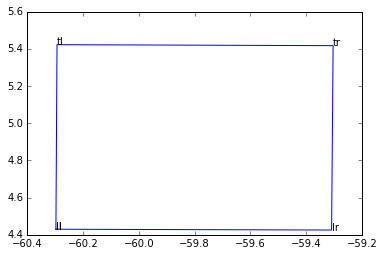

In [4]:
tl = S2_tile_data[random.choice(list(S2_tile_data.keys()))]
order = ["ll","lr","tr","tl","ll"]
plot([tl["pos"][pp]["lon"] for pp in order],
     [tl["pos"][pp]["lat"] for pp in order])
for pp in order:
    text(tl["pos"][pp]["lon"],tl["pos"][pp]["lat"],pp)

In [5]:
res = {'res10_cols': 10980,'res10_rows': 10980,
       'res20_cols': 5490,'res20_rows': 5490,
       'res60_cols': 1830,'res60_rows': 1830}
S2_tile_data["res"] = res

In [6]:
with open("./S2_tile_data.json","w") as fl:
    json.dump(S2_tile_data,fl)

In [7]:
with open("./S2_tile_data.json","r") as fl:
    S2_tile_data = json.load(fl)
print(len(S2_tile_data.keys()))

56687


In [8]:
sf = shapefile.Reader("./world/world_countries_boundary_file_world_2002")
recs    = sf.records()
shapes  = sf.shapes()
Nshp    = len(shapes)

In [9]:
shapes_boxes = {rec[0]:{"shpe":shapely.geometry.shape(shape),
                        "box":shapely.geometry.box(*shapely.geometry.shape(shape).bounds)} for rec,shape in zip(recs,shapes)}

In [ ]:
for key,ti in S2_tile_data.items():
    if "pos" in S2_tile_data[key]:
        S2_tile_data[key]["country"] = []
        S2_tile_data[key]["region"] = []

for key,ti in tqdm(S2_tile_data.items()):
    if "pos" in S2_tile_data[key]:
    #if "pos" in S2_tile_data[key] and key == "32UPC":
    #if "pos" in S2_tile_data[key] and key[:2] == "32":
        for rec,shape in zip(recs,shapes):
            shpe = shapes_boxes[rec[0]]["shpe"]
            box = shapes_boxes[rec[0]]["box"]
            in_box = False
            for _,pt in ti["pos"].items():         
                if box.contains(shapely.geometry.Point(([pt["lon"],pt["lat"]]))):
                    if shpe.contains(shapely.geometry.Point(([pt["lon"],pt["lat"]]))):
                        in_box = True
                        break
                    
            if in_box is True:
                if rec[0] not in S2_tile_data[key]["country"]:
                    S2_tile_data[key]["country"].append(rec[0])
                if rec[-3] not in S2_tile_data[key]["region"]:
                    S2_tile_data[key]["region"].append(rec[-3])

 18%|█▊        | 9986/56687 [07:18<35:18, 22.05it/s]

In [ ]:
S2_tile_data["32VMK"],S2_tile_data["33UWV"]

In [ ]:
with open("./S2_tile_data_full.json","w") as fl:
    json.dump(S2_tile_data,fl)
    
S2_tile_data_short = {key:{pp:{pj:value["pos"][pp][pj] for pj in ["lon","lat"]} for pp in ["ll","tl","lr","tr"]} for key,value in S2_tile_data.items() if key != "res" and "p1" not in value["pos"]}
with open("./S2_tile_data_lite.json","w") as fl:
    json.dump(S2_tile_data_short,fl)